In [1]:
import pandas as pd
import numpy as np
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
# LOAD DATA
train_df= pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')
store_df = pd.read_csv('../data/store.csv')

In [3]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from cleaner import DfCleaner
from df_outlier import DfOutlier
from file_handler import FileHandler

from df_overview import DfOverview
from vis_seaborn import VisSeaborn

2022-05-26 14:29:59,104 — DfCleaner — DEBUG — Loaded successfully!
2022-05-26 14:29:59,108 — DfOutlier — DEBUG — Loaded successfully!
2022-05-26 14:29:59,113 — DfOverview — DEBUG — Loaded successfully!


In [4]:
sn = VisSeaborn()
file_handler = FileHandler()


In [5]:
stores_types = ["Store type A", "Store type B", "Store type C", "Store type D"]
state_holidays = [ "Normal Day", "Public holiday", "Easter holiday", "Christmas"] 
school_holidays = ["School is closed", "School is open"]
assortment = [ "Basic", "Extra", "Extended"] 
promo = ["Not participating", "Participating"]
store_open = ["Closed", "Open"]

#  Exploration of customer purchasing behavior

step 1 Check for distribution in both training and test sets - are the promotions distributed similarly between these two groups?

In [6]:
train_data= train_df.copy()
test_data = test_df.copy()
train_data

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1485,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,1,1
1017205,1112,2,2013-01-01,0,0,0,0,1,1
1017206,1113,2,2013-01-01,0,0,0,0,1,1
1017207,1114,2,2013-01-01,0,0,0,0,1,1


In [7]:
def compare_test_train(train_data, test_data, feature, title):
  fig, ax = plt.subplots(1, 2, sharex=True, figsize=(12, 4))
  ax[0].set_title("Train " + title)
  sns.countplot(x=feature, data=train_data, ax=ax[0])
  ax[1].set_title("Test " + title)
  sns.countplot(x=feature, data=test_data, ax=ax[1])
  fig.subplots_adjust(wspace=0.3)
  fig.show()

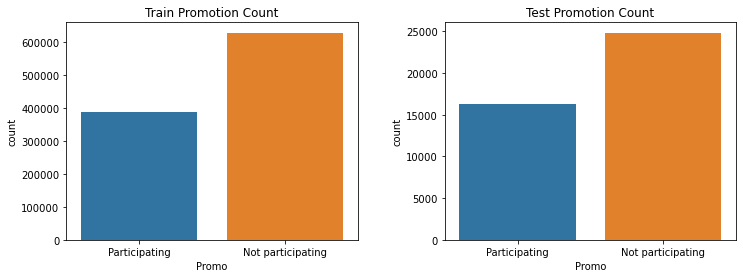

In [8]:
# Promotion comparision between train and test data
train_data["Promo"] = train_data["Promo"].apply(lambda x: promo[x])
test_data["Promo"] = test_data["Promo"].apply(lambda x: promo[x])
compare_test_train(train_data, test_data, 'Promo', "Promotion Count")

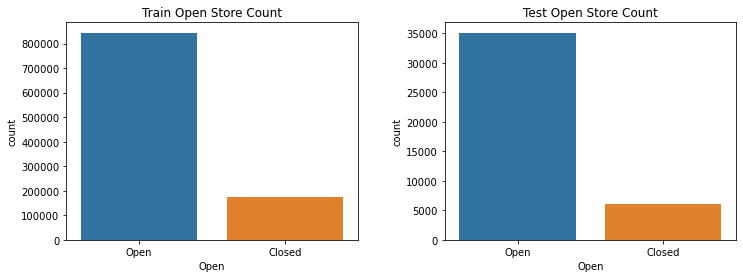

In [9]:
# Open store count
train_data["Open"] = train_data["Open"].apply(lambda x: store_open[x])
test_data["Open"] = test_data["Open"].apply(lambda x: store_open[x])
compare_test_train(train_data, test_data, 'Open', "Open Store Count")

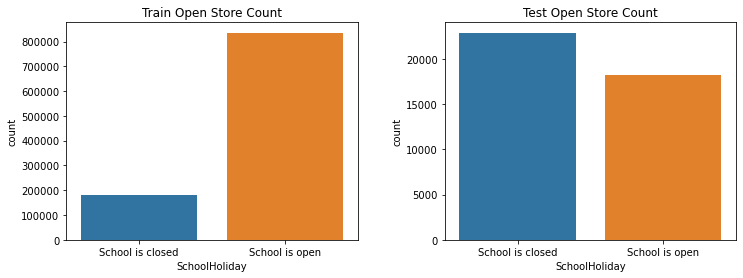

In [10]:
train_data["SchoolHoliday"] = train_data["SchoolHoliday"].apply(lambda x: school_holidays[x])
test_data["SchoolHoliday"] = test_data["SchoolHoliday"].apply(lambda x: school_holidays[x])
compare_test_train(train_data, test_data, 'SchoolHoliday', "Open Store Count")

On our test data Schools are more closed than open. This is not normal, the more representative data is the training data, in which there are far more days schools are open than closed.

In [11]:
state_holiday_train = train_data.groupby(['StateHoliday']).agg({'StateHoliday': ['count']})
state_holiday_train.columns = ['count']
state_holiday_train = state_holiday_train.reset_index()
state_holiday_train["StateHoliday"] = state_holiday_train["StateHoliday"].apply(lambda x: state_holidays[x])
state_holiday_train

,StateHoliday,count
0,Normal Day,986159
1,Public holiday,20260
2,Easter holiday,6690
3,Christmas,4100


In [12]:
state_holiday_test = test_df.groupby(['StateHoliday']).agg({'StateHoliday': ['count']})
state_holiday_test.columns = ['count']
state_holiday_test = state_holiday_test.reset_index()
state_holiday_test["StateHoliday"] = state_holiday_test["StateHoliday"].apply(lambda x: state_holidays[x])
state_holiday_test

,StateHoliday,count
0,Normal Day,40908
1,Public holiday,180


In [13]:
def plot_box_multi(df: pd.DataFrame, x_col: str, y_col: str, title: str) -> None:
        """Plot the box chart for multiple column.

        Args:
            df(pd.DataFrame): Dataframe to be plotted.
            column(str): column to be plotted.
        """
        plt.figure(figsize=(12, 7))
        sns.boxplot(data=df, x=x_col, y=y_col)
        plt.title(title, size=20)
        plt.xticks(rotation=75, fontsize=14)
        plt.yticks(fontsize=14)
       
        plt.show()


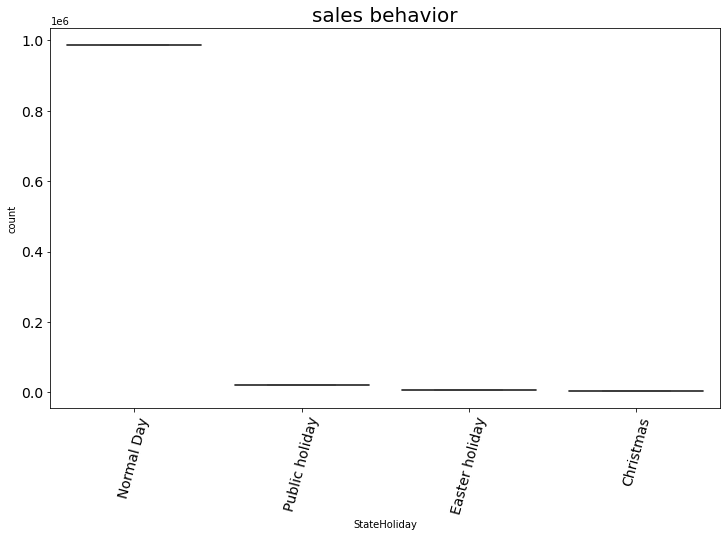

In [14]:
plot_box_multi(state_holiday_train, 'StateHoliday', 'count','sales behavior')

In [15]:
# merge the two data for further analysis
df_train_store = pd.merge(train_df.reset_index(), store_df, how='inner', on='Store')
df_train_store.shape

(1017209, 22)

In [16]:
df_train_store['Date'] = pd.DatetimeIndex(df_train_store['Date'])
df_train_store['Year'] = pd.DatetimeIndex(df_train_store['Date']).year
df_train_store['Month'] = pd.DatetimeIndex(df_train_store['Date']).month
df_train_store['Day'] = pd.DatetimeIndex(df_train_store['Date']).day

In [17]:
df = df_train_store.copy()

In [18]:
df["StoreType"] = df["StoreType"].apply(lambda x: stores_types[x])
store_type_df = df.groupby('StoreType').agg({'Customers': 'mean', 'Sales': 'mean'})
store_type_df = store_type_df.reset_index()
store_type_df

,StoreType,Customers,Sales
0,Store type A,640.025626,5640.539466
1,Store type B,1321.559760,9198.315793
2,Store type C,663.820001,5668.122113
3,Store type D,501.292724,5611.875173


In [19]:
date_df = df.groupby('Year').agg({'Customers': 'mean', 'Sales': 'mean'})
date_df = date_df.reset_index()
date_df.head()

,Year,Customers,Sales
0,2013,607.240310,5574.858876
1,2014,620.076613,5747.614674
2,2015,603.788751,5800.554264


In [20]:
def plot_trend(df, columns, feature, title, x_label="", y_label="", labels=['']):
  plt.figure(figsize=(18, 6))
  for i in range(len(columns)):
    sns.lineplot(x=df.index, y=df[columns[i]][feature], label=labels[i])
  plt.title(title, fontsize=15, fontweight='bold')
  plt.ylabel(x_label, fontsize=14)
  plt.xlabel(y_label, fontsize=14)
  plt.show()

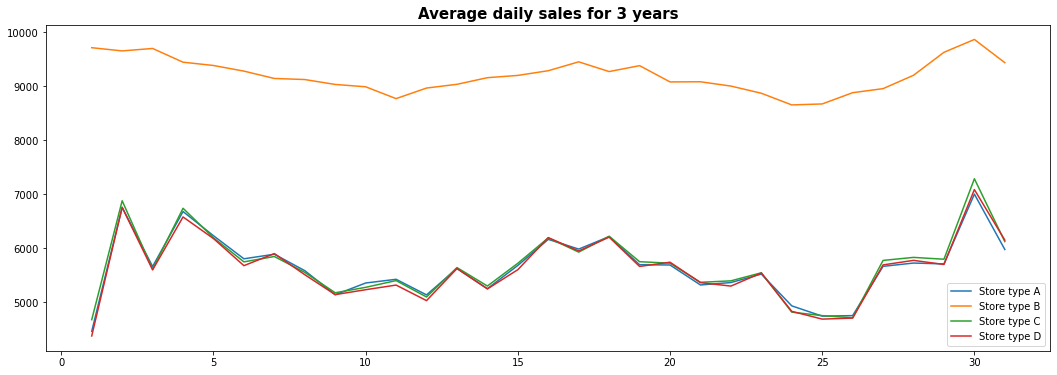

In [21]:
#Average daily sales for each store within 3 yr timeframe
daily_trend = df.groupby(['Day', 'StoreType']).agg({'Customers': 'mean', 'Sales': 'mean'})
daily_trend = daily_trend.unstack().swaplevel(0, 1, 1).sort_index(1)
columns = ["Store type A", "Store type B", "Store type C", "Store type D"]
plot_trend(daily_trend, columns, 'Sales', 'Average daily sales for 3 years', labels=columns)

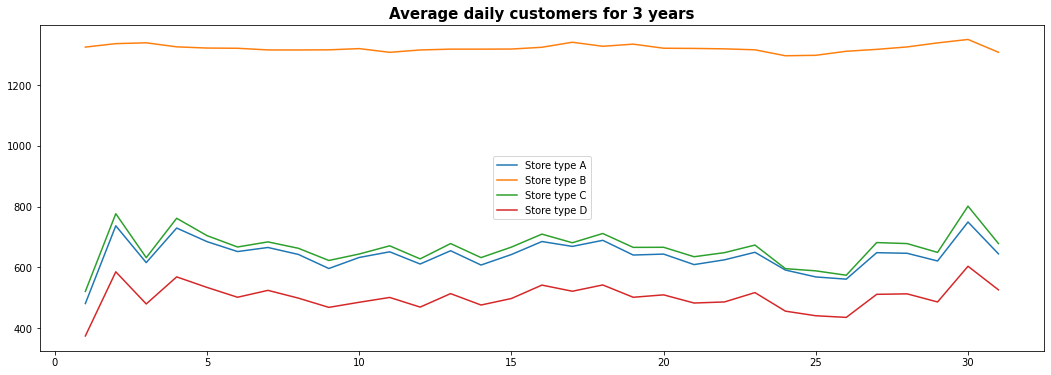

In [22]:
#Average daily customers for each store within 3 yr timeframe
plot_trend(daily_trend, columns, 'Customers', 'Average daily customers for 3 years', labels=columns)

In [23]:
df = df_train_store.copy()
corr_all = df_train_store[['Open', 'Promo', 'Promo2', 'Sales', 'Customers', 'DayOfWeek', 'StateHoliday', 'SchoolHoliday', 'StoreType',
                           'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']].corr()


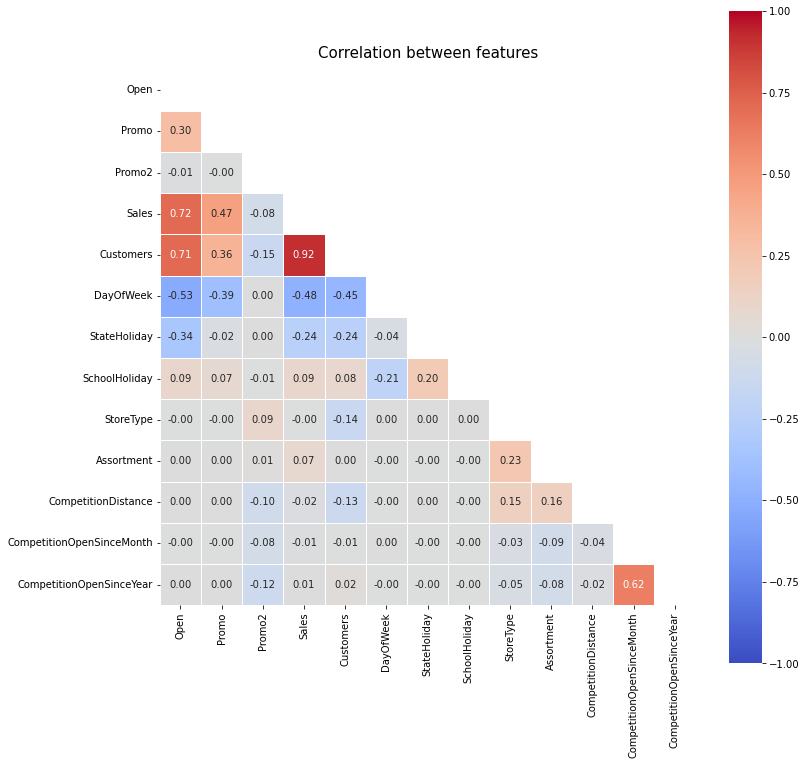

In [24]:
mask = np.zeros_like(corr_all, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(230, 20, as_cmap=True)

fig, ax = plt.subplots(figsize=(12, 12))
heatmap = sns.heatmap(corr_all, mask=mask, square=True, linewidths=.5,
                      vmin=-1, vmax=1, cmap='coolwarm', annot=True, fmt='.2f')
heatmap.set_title('Correlation between features', fontdict={'fontsize': 15}, pad=12)
fig.show()

From the above correlation matrix there is a strong positive correlation between sales and customers.Promo has a positive correation with sales and customers.State holidays and days of the week have a negative correlation with sales and customers.

Impact of Promo on customers and sales

In [25]:
df["Promo"] = df["Promo"].apply(lambda x: promo[x])
df["Promo2"] = df["Promo2"].apply(lambda x: promo[x])
overall_trend = df.groupby(['Promo', 'Promo2',]).agg({'Customers': 'mean', 'Sales': 'mean'})
overall_trend

Customers        Sales
Promo             Promo2                                    
Not participating Not participating  549.897722  4653.153223
                  Participating      451.173358  4082.995225
Participating     Not participating  858.882874  8163.343938
                  Participating      722.376830  7508.553109

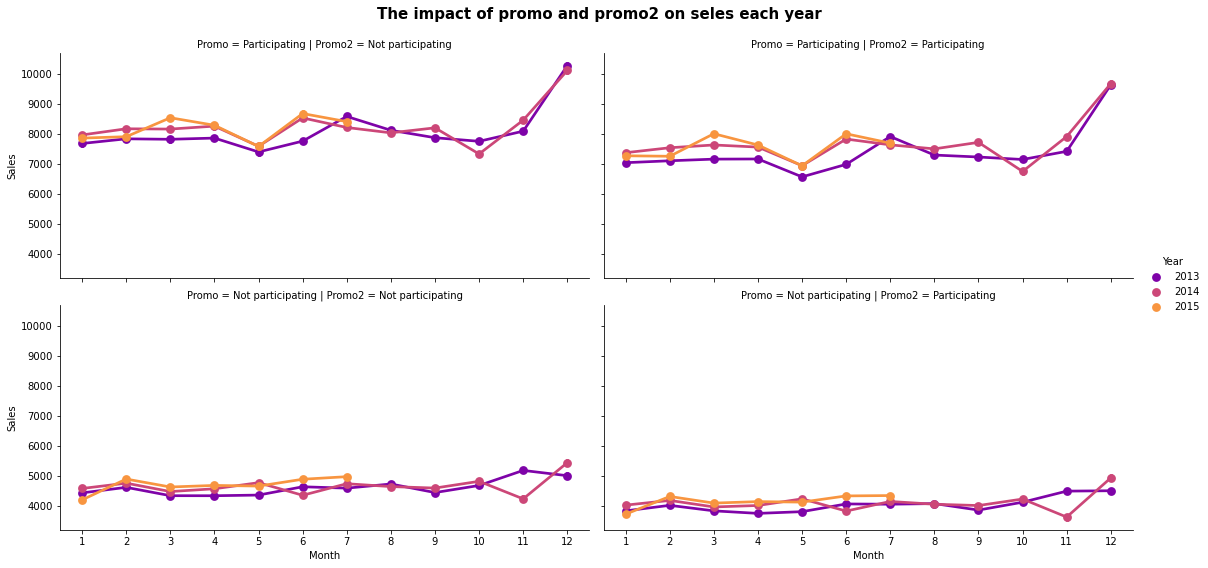

In [26]:
fp = sns.factorplot(data=df, x='Month', y="Sales", palette='plasma', hue='Year',
                    row='Promo', col='Promo2', color='green', size=4, aspect=2)
fp.fig.subplots_adjust(top=.9) 
fp.fig.suptitle("The impact of promo and promo2 on seles each year", fontsize=15, fontweight='bold')
plt.show()

This is the most interesting plot, I think. Promo 1 has a positive impact on sales and there is clearly more sales when the promo is running.
Promo2 has a little bit of a negative impact on sales.


CONCLUSION

We can conclude that the corporation should stop investing in Promo2 and instead concentrate on Promo.
